# PyTorch Transfer Learning

 1.   Freezing all the layers except the final one
 2.   Freezing the first few layers
 3.   Fine-tuning the entire network.

The following pre-trained models are available on PyTorch

 *   resnet18, resnet34, resnet50, resnet101, resnet152
 *   squeezenet1_0, squeezenet1_1
 *   Alexnet
 *   inception_v3
 *   Densenet121, Densenet169, Densenet201
 *   Vgg11, vgg13, vgg16, vgg19, vgg11_bn. vgg13_bn, vgg16_bn, vgg19_bn

In [1]:
import sys
sys.version

'3.6.6 (default, Sep 12 2018, 18:26:19) \n[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]'

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
#import torch

In [3]:
!pip install Pillow
!pip install image

In [0]:
%matplotlib inline

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [6]:
import torch
print(torch.__version__)

0.4.1


In [7]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [8]:
torch.cuda.is_available()

True

### Get Data

In [0]:
from zipfile import ZipFile

files = os.listdir()
if not 'stanford-car-dataset-by-classes-folder.zip' in files:
  !curl --header 'Host: storage.googleapis.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:63.0) Gecko/20100101 Firefox/63.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://www.kaggle.com/' --cookie '_ga=GA1.3.597929118.1540370868' --header 'Upgrade-Insecure-Requests: 1' 'https://storage.googleapis.com/kaggle-datasets/31559/46697/stanford-car-dataset-by-classes-folder.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1542721521&Signature=IxuMf2cYrqPLZnHwIN%2FYgqjB4AmZRlc1tic2zQvw7riMnj7iyKNL%2FTr9APeH85Pn6xPszzlYPG2l3aGPteZM0Lg8mxB%2F%2FezvHLvTWJyTa92YPcIyOsOsGl%2BVARVsCJzjDRn4p%2FoBc7sSjUwH5JLC4w7F2EDRSYV%2FC5lXY1O3ffq%2Fw9GVeccbn%2B1jEkjvt31R5kt4ElkfUo9x0vWNO78VsPnxGZgBiiT6AoIx%2FKpCuzZFeIhAO5XctdXWNlIBKnjVZ4iy0bIbBD5aabZa1S%2B4GkjSQSx6TxkGj8%2BsUHFuCtZfmsQ6eenU6l3ZVRJ%2FwbuX6IJn7T29WaV2Ui2MQXMuYg%3D%3D' --output 'stanford-car-dataset-by-classes-folder.zip'
  #!curl --header 'Host: download.pytorch.org' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:63.0) Gecko/20100101 Firefox/63.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html' --cookie '_ga=GA1.2.790875021.1539437510; _gid=GA1.2.1387431237.1542471753' --header 'Upgrade-Insecure-Requests: 1' 'https://download.pytorch.org/tutorial/hymenoptera_data.zip' --output 'hymenoptera_data.zip'
  !ls
  full_file_name = "stanford-car-dataset-by-classes-folder.zip"
  with ZipFile(full_file_name, 'r') as zipF:
    zipF.extractall()
    print('Done')
  
  file_name = "car_data.zip"
  with ZipFile(file_name, 'r') as zipF:
    zipF.extractall()
    print('Done')

In [10]:
#from zipfile import ZipFile

#with ZipFile(full_file_name, 'r') as zipF:
#  zipF.extractall()
#  print('Done')

!ls

anno_test.csv	car_data.zip  stanford-car-dataset-by-classes-folder.zip
anno_train.csv	names.csv
car_data	sample_data


In [0]:
#file_name = "car_data.zip"

#with ZipFile(file_name, 'r') as zipF:
#  zipF.extractall()
#  print('Done')

In [0]:
data_dir = 'car_data'
#data_dir = 'hymenoptera_data'

val_dir = 'test'
#val_dir = 'val'
train_dir = 'train'

batch_size = 32

In [13]:
# again, list total number of classes, and list them all
# os.list dir sorting depends on OS dependent file indexing, so leaving it as it is

classes = os.listdir(f'{data_dir}/train')
classes.sort()
ClassesNumer = len(classes)
print("Class Total Count: ", ClassesNumer)
#print(classes)


Class Total Count:  196


In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    train_dir: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
       # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    val_dir: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
}

In [0]:

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),data_transforms[x]) for x in [train_dir, val_dir]}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in [train_dir, val_dir]}

dataset_sizes = {x: len(image_datasets[x]) for x in [train_dir, val_dir]}

class_names = image_datasets[train_dir].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [16]:
print(dataloaders)
print(dataset_sizes)
print(device)

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f77deba4080>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f77deba4b00>}
{'train': 8144, 'test': 8041}
cuda:0


In [17]:
print(image_datasets[train_dir])


Dataset ImageFolder
    Number of datapoints: 8144
    Root Location: car_data/train
    Transforms (if any): Compose(
                             RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                         )
    Target Transforms (if any): None


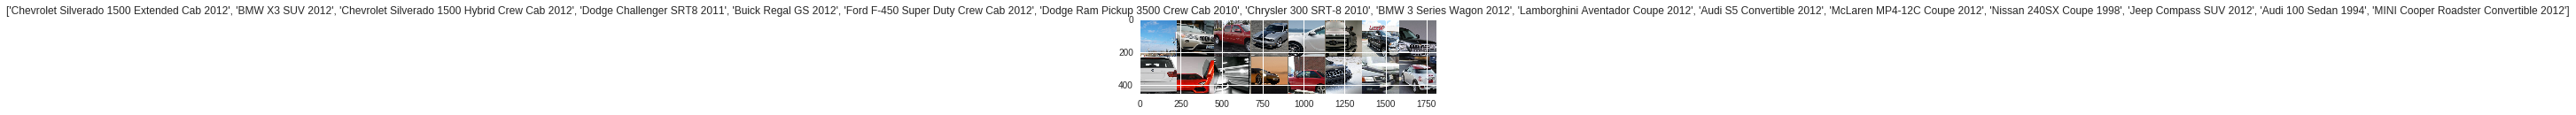

In [18]:
#Let’s visualize a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders[train_dir]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

###Training the model

Now, let’s write a general function to train a model. Here, we will illustrate:

    Scheduling the learning rate
    Saving the best model

In the following, parameter ''scheduler'' is an LR scheduler object from ''torch.optim.lr_scheduler''.

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in [train_dir, val_dir]:
            if phase == train_dir:
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == train_dir):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == train_dir:
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == val_dir and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
# Load a pretrained model and reset final fully connected layer
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft.fc = nn.Linear(num_ftrs, ClassesNumer)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:09<00:00, 24333655.70it/s]


In [23]:
# Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 4.9205 Acc: 0.0436
test Loss: 3.9968 Acc: 0.1334

Epoch 1/24
----------
train Loss: 3.7535 Acc: 0.1815
test Loss: 2.7051 Acc: 0.3470

Epoch 2/24
----------
train Loss: 2.8789 Acc: 0.3353
test Loss: 1.8783 Acc: 0.5091

Epoch 3/24
----------
train Loss: 2.2662 Acc: 0.4695
test Loss: 1.4071 Acc: 0.6293

Epoch 4/24
----------
train Loss: 1.8176 Acc: 0.5640
test Loss: 1.0922 Acc: 0.7050

Epoch 5/24
----------
train Loss: 1.5015 Acc: 0.6375
test Loss: 0.8456 Acc: 0.7682

Epoch 6/24
----------
train Loss: 1.3062 Acc: 0.6853
test Loss: 0.7449 Acc: 0.7873

Epoch 7/24
----------
train Loss: 1.0451 Acc: 0.7623
test Loss: 0.5987 Acc: 0.8398

Epoch 8/24
----------
train Loss: 0.9592 Acc: 0.7862
test Loss: 0.5966 Acc: 0.8417

Epoch 9/24
----------
train Loss: 0.9229 Acc: 0.7979
test Loss: 0.5672 Acc: 0.8489

Epoch 10/24
----------
train Loss: 0.9114 Acc: 0.7949
test Loss: 0.5575 Acc: 0.8524

Epoch 11/24
----------
train Loss: 0.8983 Acc: 0.8021
test Loss: 0.5558 Acc

In [0]:
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders[val_dir]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

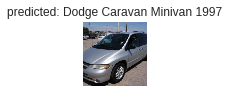

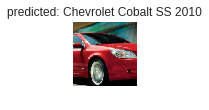

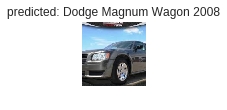

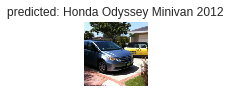

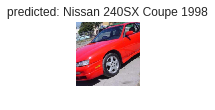

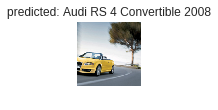

In [25]:
visualize_model(model_ft)

ConvNet as fixed feature extractor: Training only the last fully connected layer
----------------------
Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [0]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default

## Change the last layer
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, ClassesNumer)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
# Train and evaluate
# This is expected as gradients don't need to be computed for most of the network. 
# However, forward does need to be computed.

#model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

In [0]:
#visualize_model(model_conv)

#plt.ioff()
#plt.show()